# Ch 3. 분류

### 사이킷런에서 MNIST 다운받기

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
print("X.shape =", X.shape, "y.shape =", y.shape)

X.shape = (70000, 784) y.shape = (70000,)


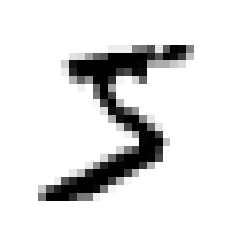

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

some_digit = X.to_numpy()[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [4]:
y[0]

'5'

In [5]:
y = y.astype(np.uint8)

### training set, test set 나누기

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3.2 이진 분류기 (5 판별기)

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
y_train_5[:5]

0     True
1    False
2    False
3    False
4    False
Name: class, dtype: bool

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit])

/Users/kakao/Projects/hands-on-machine-learning/venv/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

## 3.3 성능 측정

### 3.3.1 k-fold cross validation

In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

- 정확도가 95% 이상이 나왔다!

In [11]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=4, scoring="accuracy")

array([0.91213333, 0.90726667, 0.9102    , 0.909     ])

- 무조건 false라고 판단하면 정확도가 90% 정확도이다!
- **분류기의 성능 척도로 정확도를 사용하지 않는 이유**이다.
- 특히 데이터 분표가 편향되어 있을수록 정확도는 좋은 척도가 아니다

### 3.3.2 오차 행렬

In [13]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

정밀도와 재현율

**정밀도**: 양성 예측의 정확도

**재현율**: 분류기가 정확하게 감지한 양성 샘플의 비율

In [16]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)
recall_score(y_train_5, y_train_pred)

0.6511713705958311

### 3.3.4 정밀도/재현율 트레이드 오프

판단을 할 때 임계값을 높이면 정밀도는 높아지지만 재현율은 낮아진다.

In [17]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

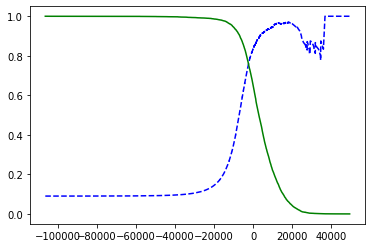

In [18]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
    plt.plot(thresholds, recalls[:-1], "g-", label="재현율")
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

### 3.3.5 ROC 곡선

ROC(Receiver Operating characteristic) 곡선은 **거짓 양성 비율(false positive rate, FPR)**에 대한 **진짜 양성 비율(true positive rate, TPR)**의 비율이다.

In [19]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

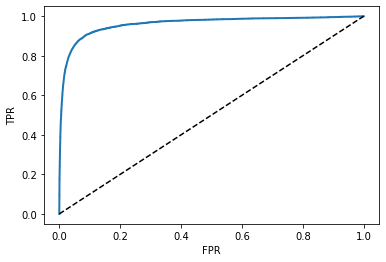

In [20]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    
plot_roc_curve(fpr, tpr)
plt.show()

- 그래프가 y=x 선에서 최대한 떨어져 그래프 아래 면적(AUC, area under the curve)이 넓을수록 좋은 분류기이다.

RandomForestClassifier와 SGDClassifier의 ROC 및 AUC 점수를 비교해보자.

In [21]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [22]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

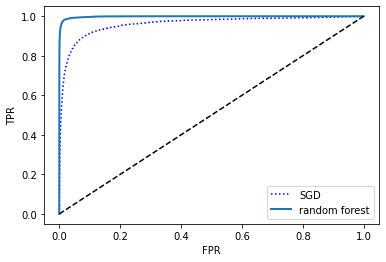

In [23]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "random forest")
plt.legend(loc="lower right")
plt.show()

# 다중 분류

- 이미지 분류시 각 분류기의 결정 점수 중 가장 높은 것을 클래스로 선택하는 것을 OvR(one-versus-the-rest) 또는 OvA(one-versus-all)이라고 부른다. 반면 0과 1, 1과 2, 0과 2와 같은 각 숫자의 조합마다 이진 분류기를 훈련시키는 것을 OvO(one-versus-one)전략이라고 한다.


In [24]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

KeyboardInterrupt: 

In [ ]:
# from sklearn.multiclass import OneVsRestClassifier
# ovr_clf = OneVsRestClassifier(SVC())
# ovr_clf.fit(X_train, y_train)
# ovr_clf.predict([some_digit])

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [ ]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")


# 에러 분석
모델이 한 가지 특정되었다고 가정하고 에러 분석을 통해 모델의 성능을 향상시키는 방법을 찾아보자.

### 오차 행렬

In [ ]:
# y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
# conf_mx = confusion_matrix(y_train, y_train_pred)
# conf_mx

In [ ]:
plt.metshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

# 다중 레이블 분류

- 각각의 샘플마다 분류기가 여러 클래스를 출력해야 하는 경우 ex) [0, 1, 1]

In [27]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [28]:
knn_clf.predict([some_digit])

/Users/kakao/Projects/hands-on-machine-learning/venv/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

In [29]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

NameError: name 'f1_score' is not defined

# 다중 출력 분류

- 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화 한 것

In [35]:
X_train.astype(np.float64)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [40]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row: (row + 1) * images_per_row]
        row_i


In [44]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.to_numpy()[0]])
plot_digits(clean_digit)

/Users/kakao/Projects/hands-on-machine-learning/venv/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


NameError: name 'row_i' is not defined